In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
!pip install h2o
!pip install lightgbm

    100% |████████████████████████████████| 120.9MB 183kB/s 
  Stored in directory: /root/.cache/pip/wheels/80/d9/27/eba7cef0f0cacb7a31fa32d7086dec0c9726d770593e374e7c
Successfully built h2o


In [3]:

import seaborn as sns
import os
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import h2o

import lightgbm as lgb

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import nltk
from nltk.corpus import stopwords
import string

from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns
link = 'https://drive.google.com/open?id=1udJeq9cYA5BTagIh2I_TcBiqYn8FxJaj'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
train = pd.read_csv('train.csv',sep='~')
link = 'https://drive.google.com/open?id=1P0NgTOvLwUznerU0grO-dU-6ASCKgeBn'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')  
test = pd.read_csv('test.csv',sep='~')
train.head()

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,11755,After reading mixed reviews I almost didn't bo...,Google Chrome,Desktop,Good
1,33912,This motor inn is located about - city blocks ...,Firefox,Tablet,Good
2,10143,It was our first time there and surely not our...,Google Chrome,Mobile,Good
3,33114,"Great hotel in an excellent location, just off...",Mozilla,Desktop,Good
4,17464,We stayed at the hotel for - weeks to get away...,Google Chrome,Desktop,Good


In [0]:
Browser = ['Firefox','Edge','Google Chrome','InternetExplorer','Mozilla Firefox',
           'Mozilla','IE','Chrome','Internet Explorer','Safari','Opera']
Device = ['Desktop','Mobile','Tablet']

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Good    20567
Bad      9605
Name: Is_Response, dtype: int64

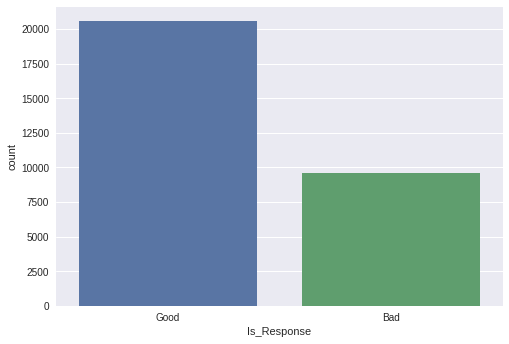

In [7]:
#Is_Response Analysis
#Due to this for evaluation we used F1 score
c1 = sns.countplot(train['Is_Response'])
train['Is_Response'].value_counts()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Mobile     11639
Desktop    11630
Tablet      6903
Name: Device_Used, dtype: int64

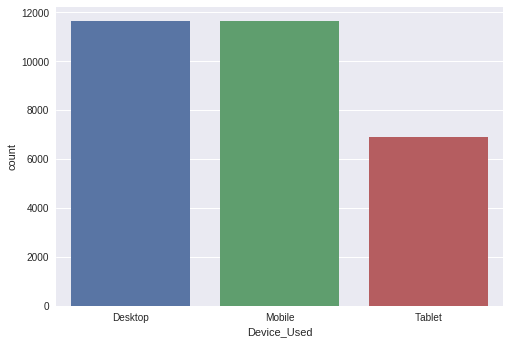

In [8]:
#Device Distribution count
c1 = sns.countplot(train['Device_Used'],order=['Desktop','Mobile','Tablet'])
train['Device_Used'].value_counts()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Good    20567
Bad      9605
Name: Is_Response, dtype: int64

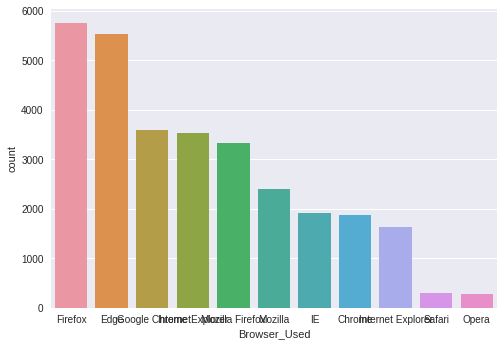

In [9]:
c1 = sns.countplot(train['Browser_Used'],order=Browser)
train['Is_Response'].value_counts()

In [0]:
#Encode the target variable 
stars_dict = {'Good':1,'Bad':0}
train["Is_Response"] = train['Is_Response'].replace(stars_dict,regex=True)

In [11]:
import nltk
nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


For EDA , it might be a good idea to create some metafeatures.The metafeatures that we'll create are:

Number of words in the text
Number of unique words in the text
Number of characters in the text
Number of stopwords
Number of punctuations
Number of upper case words
Number of title case words
Average length of the words

In [0]:
## Number of words in the text ##
train["num_words"] = train["Description"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["Description"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train["num_unique_words"] = train["Description"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["Description"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train["num_chars"] = train["Description"].apply(lambda x: len(str(x)))
test["num_chars"] = test["Description"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["Description"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["num_stopwords"] = test["Description"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train["num_punctuations"] =train['Description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['Description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train["num_words_upper"] = train["Description"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["Description"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_title"] = train["Description"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["Description"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["Description"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["Description"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


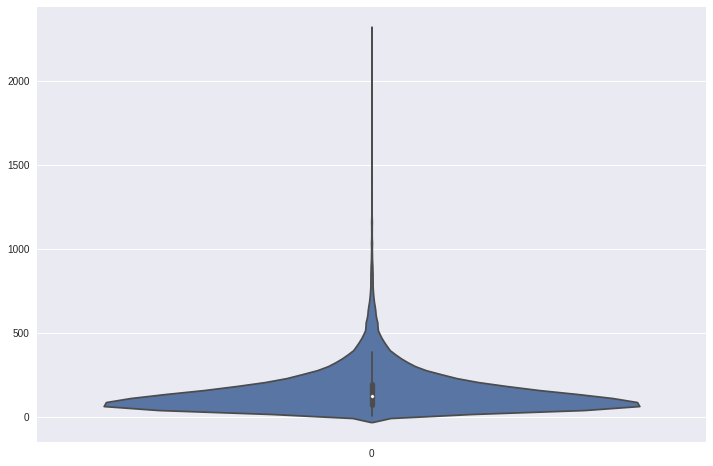

157.1324075301604

In [14]:
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_words'])
plt.show()
train['num_words'].mean()
#So most of the Description are having lenght of 157 and almost all are under 500

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


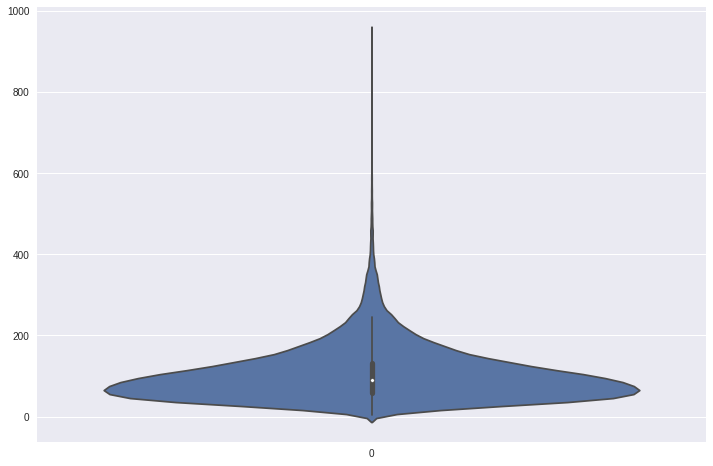

In [15]:
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_unique_words'])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


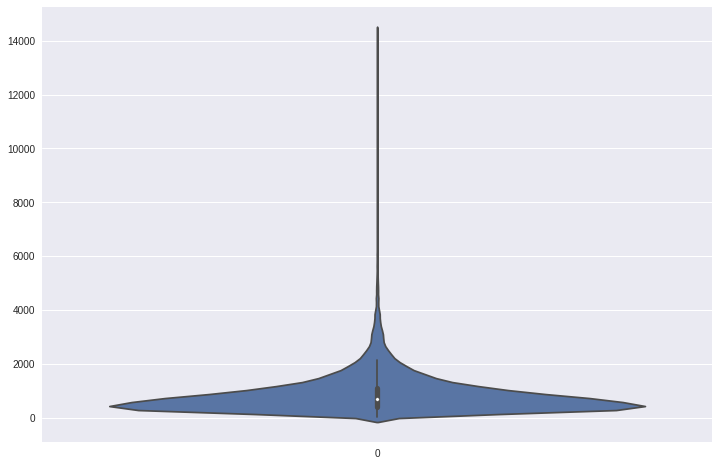

In [16]:
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_chars'])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


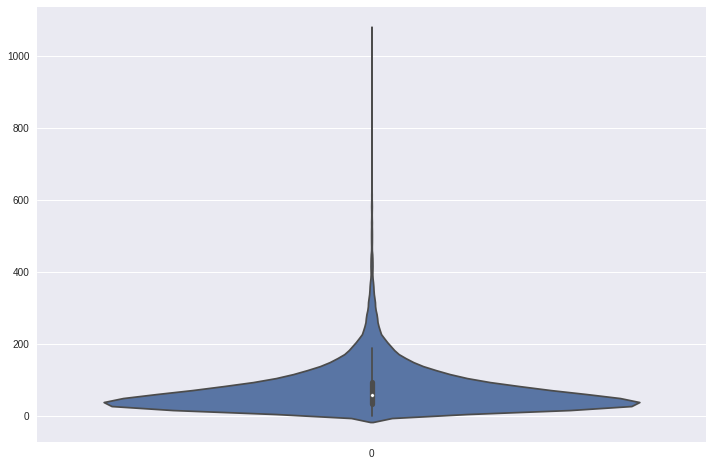

In [17]:
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_stopwords'])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


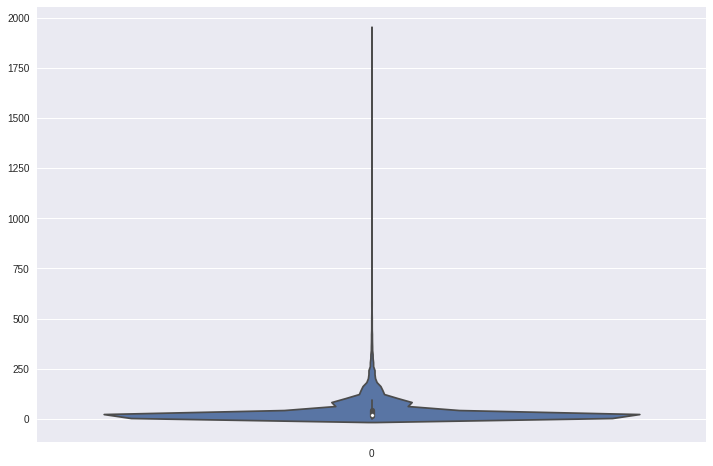

In [18]:
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_punctuations'])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


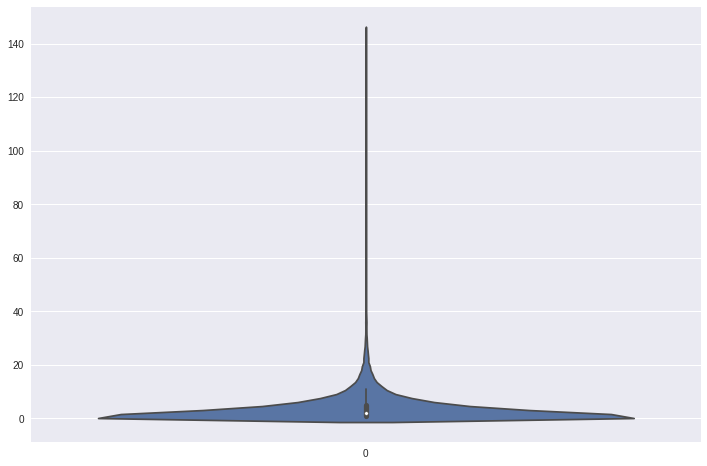

In [19]:
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_words_upper'])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


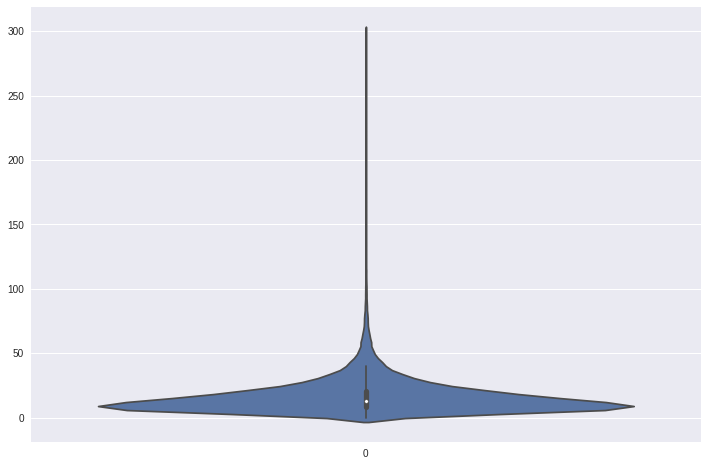

In [20]:
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_words_title'])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


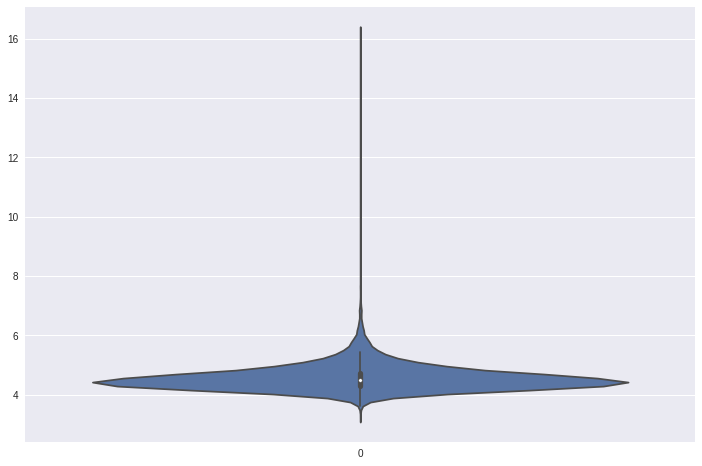

In [21]:
plt.figure(figsize=(12,8))
sns.violinplot(data=train['mean_word_len'])
plt.show()
#Lenght of most word lies between 4 to 5

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


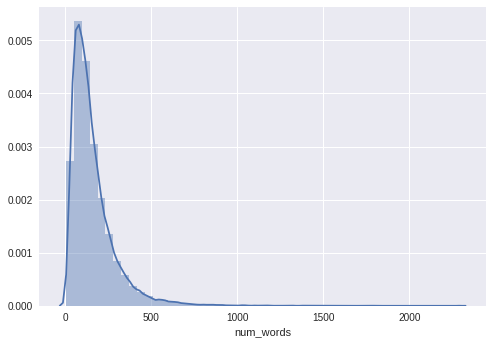

In [22]:
d1 = sns.distplot(train['num_words'])
#Distribution of word 

In [24]:
#Find the most common word across
freq = pd.Series(' '.join(train['Description']).split()).value_counts()[:20]
print(freq)

# Most common words are : the , and , a , to , was

the      248806
and      162205
a        132566
to       120620
was      103169
I         76959
in        71656
of        64365
The       61001
is        58109
for       55194
we        40132
hotel     38576
at        36896
were      36094
room      35803
with      33836
it        33553
but       32770
that      32739
dtype: int64


In [25]:
#List of word occur only once in the entire context
freq = pd.Series(' '.join(train['Description']).split()).value_counts()[-18000:]
print(freq)

instructions!                              1
ordered),                                  1
walking),                                  1
(Lyndhurst)                                1
coffemaker                                 1
were.....very                              1
(M-Th.only).                               1
HUP.                                       1
LeSpa                                      1
Heritage!                                  1
before"""""""""""""""""""""""""""""""".    1
around--but                                1
hours.....presumably                       1
Charlie.                                   1
Shelbourne                                 1
Comfort-Inn                                1
well.But                                   1
alterations                                1
phased                                     1
Ckean                                      1
AMC,                                       1
dispayed                                   1
(shipping 

In [0]:
train_target = train['Is_Response']
del train['Is_Response']

In [0]:
#Now model the same with tfidf and logistic regression
train_text = train['Description']
test_text = test['Description']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=5000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [52]:
kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred_tf = 0
oof_pred_tf = np.zeros([train.shape[0],])

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train))):
    x_train, x_val = train_word_features[train_index,:], train_word_features[val_index,:]
    y_train, y_val = train_target[train_index], train_target[val_index]
    classifier = LogisticRegression(class_weight = "balanced", C=0.5, solver='sag')
    classifier.fit(x_train, y_train)
    val_preds = classifier.predict_proba(x_val)[:,1]
    preds = classifier.predict_proba(test_word_features)[:,1]
    #test_pred_tf += 0.2*preds
    oof_pred_tf[val_index] = val_preds

5it [00:02,  1.84it/s]


In [55]:
pred_train = (oof_pred_tf > 0.3).astype(np.int)
f1_score(train_target, pred_train)
print(preds)

[0.17377676 0.5951362  0.92246787 ... 0.86254866 0.4574228  0.44454378]


In [57]:

for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score(train_target, (oof_pred_tf>thresh).astype(int))))

F1 score at threshold 0.1 is 0.8602358480650789
F1 score at threshold 0.11 is 0.8648076841704396
F1 score at threshold 0.12 is 0.8690990320178704
F1 score at threshold 0.13 is 0.8733919818489266
F1 score at threshold 0.14 is 0.8771303150284041
F1 score at threshold 0.15 is 0.8804655892343306
F1 score at threshold 0.16 is 0.884063016798677
F1 score at threshold 0.17 is 0.8871052401364709
F1 score at threshold 0.18 is 0.8897188049209138
F1 score at threshold 0.19 is 0.8925616187471038
F1 score at threshold 0.2 is 0.895244429664117
F1 score at threshold 0.21 is 0.8971292398832988
F1 score at threshold 0.22 is 0.8992261931386144
F1 score at threshold 0.23 is 0.9014464109244452
F1 score at threshold 0.24 is 0.9031079435247418
F1 score at threshold 0.25 is 0.9051577683647813
F1 score at threshold 0.26 is 0.9063871393164918
F1 score at threshold 0.27 is 0.9076923076923076
F1 score at threshold 0.28 is 0.9090659151831741
F1 score at threshold 0.29 is 0.9093836246550138
F1 score at threshold 0.

In [58]:
check_1 = (preds>0.39).astype(int)
out_df = pd.DataFrame({"User_ID":test["User_ID"].values})
out_df['Is_Response'] = check_1
stars_dict = {1:'Good',0:'Bad'}
out_df["Is_Response"] = out_df['Is_Response'].replace(stars_dict,regex=True)
out_df.to_csv("submission_log.csv", index=False)
out_df.head()

,User_ID,Is_Response
0,9602,Bad
1,8749,Good
2,15500,Good
3,5495,Good
4,18570,Good


In [47]:
print(preds)

[0.17380625 0.59518084 0.92247927 ... 0.86255315 0.45742351 0.44458158]
